In [1]:
%load_ext autoreload
%autoreload 2

import json
from itertools import chain

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()

from biobank_olink.constants import PROJECT_ROOT

In [2]:
results = [json.load(p.open()) for p in (PROJECT_ROOT / "results").iterdir()
           if p.name.startswith("cross_sectional") and "_adj_" not in p.name]
results = pd.DataFrame(chain.from_iterable(results))

group_cols = ["lifestyle", "ext", "olink", "panel"]
agg_values = {f"mean_{v}": (v, "mean") for v in
              ["auc_score", "best_trial_score", "num_trials", "best_trial_no", "n_estimators"]}
# remove IMMUNE and INFL2 panels since there is its sum IMMUNE_INFL2
results = results.loc[~results.panel.isin(("IMMUNE", "INFL2"))].copy()
results.groupby(group_cols, dropna=False).agg(**agg_values, count=("model", 'size'))

mean_auc_score  mean_best_trial_score  \
lifestyle ext   olink panel                                                 
False     False False ALL                 0.664918               0.665221   
True      False False ALL                 0.696197               0.696867   
          True  False ALL                 0.722158               0.721680   
                True  ALL                 0.795339               0.793580   
                      BP                  0.761772               0.760060   
                      ENDOTHELIAL         0.739792               0.739149   
                      IMMUNE_INFL2        0.755177               0.755594   
                      RENAL               0.764207               0.762610   

                                    mean_num_trials  mean_best_trial_no  \
lifestyle ext   olink panel                                               
False     False False ALL                     156.0               130.4   
True      False False ALL                     157.0               120.2   
          True  False ALL                     157.0               113.6   
                True  ALL                     157.0               126.4   
                      BP                      157.0               131.4   
                      ENDOTHELIAL             157.0               107.8   
                      IMMUNE_INFL2            157.0               128.2   
                      RENAL                   157.0               134.8   

                                    mean_n_estimators  count  
lifestyle ext   olink panel                                   
False     False False ALL                      1192.6      5  
True      False False ALL                      3362.2      5  
          True  False ALL                      3508.2      5  
                True  ALL                      4373.2      5  
                      BP                       3842.4      5  
                      ENDOTHELIAL              4020.8      5  
                      IMMUNE_INFL2             4140.4      5  
                      RENAL                    4133.0      5

In [3]:
results_gb = results.groupby(group_cols, dropna=False, as_index=False)
results_aucs = results_gb.agg({"auc_score": "mean", "x_shape": lambda v: v.values[0][1]})
results_aucs["exp_case"] = "age+sex"
results_aucs["exp_case"] += results_aucs[group_cols[:-2]].apply(
    lambda row: "".join(f"+{v}" for v in row.index[row]), axis=1)
results_aucs["exp_case"] += results_aucs.panel.apply(lambda v: f"+{v}").where(results_aucs.olink,
                                                                              "").str.lower()
results_aucs = results_aucs.set_index(["exp_case", "x_shape"])[["auc_score"]]
results_aucs.sort_index(level=1, inplace=True)
results_aucs.index = [f"{name} ({num_col})" for name, num_col in results_aucs.index.to_flat_index()]
results_aucs.index.name = "exp_case"
results_aucs

,auc_score
exp_case,
age+sex (2),0.664918
age+sex+lifestyle (18),0.696197
age+sex+lifestyle+ext (35),0.722158
age+sex+lifestyle+ext+bp (219),0.761772
age+sex+lifestyle+ext+endothelial (237),0.739792
age+sex+lifestyle+ext+renal (348),0.764207
age+sex+lifestyle+ext+immune_infl2 (988),0.755177
age+sex+lifestyle+ext+all (2750),0.795339


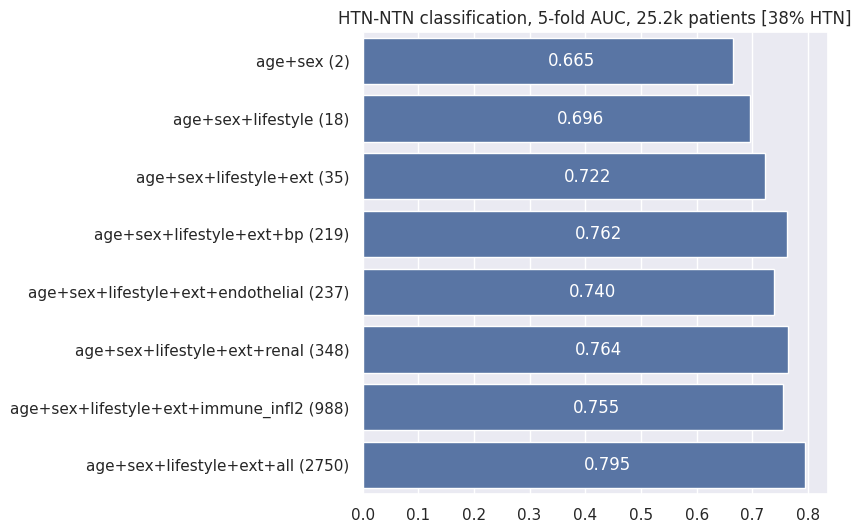

In [4]:
plt.figure(figsize=(6, 6))
ax = sns.barplot(data=results_aucs.reset_index(), y="exp_case", x="auc_score")
for p in ax.patches:
    width = p.get_width()
    plt.text(
        width / 2,
        p.get_y() + p.get_height() / 2,
        '{:.3f}'.format(width),
        va='center', color="white"
    )
plt.ylabel(None)
plt.xlabel(None)
plt.title("HTN-NTN classification, 5-fold AUC, 25.2k patients [38% HTN]")
plt.show()